In [1]:
from bloch.utils import *
from bloch.epg_transforms import *

import autograd.numpy as np
# no GPUs
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''

import tensorflow as tf

import scipy.optimize
import time as time

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/home/pkllee/anaconda2/envs/tf3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''


In [2]:
# returns a function that can be executed to run graph 
# Setting do_log=True will write a tensorboard file to .tmp/
# setting symmetrical=False will make TE_plus and TE_minus separate variables
def make_dess_tf_graph(T1_tissue, T2_tissue, do_log=False, symmetrical=True, do_ratio_correction=True):    
    
    dess_tf_graph = tf.Graph()
    
    with dess_tf_graph.as_default():
        # declare constant sequence parameters
        N = 100 # number of TRs to simulate
        N_stop = -1 # point at which to stop the gradient propagation
        M0 = tf.constant(1.0)
        #T1_meniscus = tf.constant(800.)
        #T2_meniscus = tf.constant(12.)
        
        #T1_cartilage = tf.constant(1200.)
        #T2_cartilage = tf.constant(40.)
        
        #T1, T2 = (T1_cartilage, T2_cartilage)
        #T1, T2 = (T1_meniscus, T2_meniscus)
        T1, T2 = (tf.constant(T1_tissue), tf.constant(T2_tissue))
        
        kg = tf.constant(0.) # assume no diffusion to start with
        D = tf.constant(0.)
        
        phi = tf.constant(90.) # use 90 for phi so that values remain real

        # create variables to optimize over
        alpha_var = tf.Variable(20., name='alpha')
        TE_plus_var = tf.Variable(6.5, name='TE_plus')
        
        if(symmetrical):
            TE_minus_var = TE_plus_var # keep TE_minus and TE_plus equal
            print('TE_minus equal to TE_plus')
        else:
            TE_minus_var = tf.Variable(6.5, name='TE_minus')
            print('TE_minus different from TE_plus')

        
        TR_var = tf.Variable(22.5, name='TR')        
        
        # build computation graph
        FZ_init = tf_get_FZ_init(M0)        
        FZ_preflip = FZ_init
        
        M_echos_1 = tf.zeros([3,1])
        M_echos_2 = tf.zeros([3,1])        
        
        # declare operators that reuse matrices
        with tf.name_scope('bloch_operator_setup'):
            f_rf_alpha = tf_get_rf_epg(alpha_var, phi)
            f_relax_rf_to_S1 = tf_get_relax_epg(M0, TE_plus_var, T1, T2)
            f_relax_S1_to_S2 = tf_get_relax_epg(M0, TR_var - TE_plus_var - TE_minus_var, T1, T2)
            f_relax_S2_to_preflip = tf_get_relax_epg(M0, TE_minus_var, T1, T2)
        
        with tf.name_scope('dess_sim') as scope:
            for ii in range(0, N):
                with tf.name_scope('dess_TR') as scope:

                    """ Explicit """
                    #FZ_1 = tf_rf_FZ(FZ_preflip, alpha_var, phi)             
                    #FZ_S1 = tf_relax_FZ(FZ_1, M0, TE_plus_var, T1, T2)  # accumulated time = TE_plus
                    #FZ_S2 = tf_grad_FZ(tf_relax_FZ(FZ_S1, M0, TR_var - TE_plus_var - TE_minus_var, T1, T2)) # accumulated time = TR - TE_minus
                    #FZ_preflip = tf_relax_FZ(FZ_S2, M0, TE_minus_var, T1, T2) # accumulated time = TR

                    """ Reuse graph operators """
                    FZ_1 = f_rf_alpha(FZ_preflip)
                    FZ_S1 = f_relax_rf_to_S1(FZ_1)
                    FZ_S2 = tf_grad_FZ(f_relax_S1_to_S2(FZ_S1))
                    FZ_preflip = f_relax_S2_to_preflip(FZ_S2)

                    with tf.name_scope('concat_echo_1') as scope:
                        M_echo_1 = tf.expand_dims(tf.real(tf_FZ0_to_M(FZ_S1))[:, 0], 1) # to make same size as M_echos
                        M_echos_1 = tf.concat((M_echos_1, M_echo_1), axis=1)

                    with tf.name_scope('concat_echo_2') as scope:
                        M_echo_2 = tf.expand_dims(tf.real(tf_FZ0_to_M(FZ_S2))[:, 0], 1)            
                        M_echos_2 = tf.concat((M_echos_2, M_echo_2), axis=1)   

                    # stop the gradient calculation so graph runs a bit faster, this node stops back propagation 
                    # this is valid because the steadystate magnetization is a very weak function of the transient states
                    if(ii == N_stop): 
                        FZ_preflip = tf.stop_gradient(FZ_preflip)        
        
        # now calculate the crb - since we use phi = 90 degrees, all the magnetization should reside in x
        # we only consider the last state, since that has reached steady state        
        
        # this node is to reduce the number of inputs into the last stage of the graph        
        # and makes the graph visualization nicer
        with tf.name_scope('extract_steady_state') as scope:
            M_echo_last_S1 = tf.abs(M_echo_1[0, -1], 'M_ss_S1') 
            M_echo_last_S2 = tf.abs(M_echo_2[0, -1], 'M_ss_S2')
        
        with tf.name_scope('calculate_crb_obj') as scope:
            M_S1 = M_echo_last_S1
            M_S2 = M_echo_last_S2
            
            if(do_ratio_correction):
                M_ratio = M_S2 / M_S1

                J = tf.gradients(M_ratio, T2, name='dM_dtiss_param') # tf gradients returns a list
                fim = J[0] * J[0] # fischer information matrix
                V = 1. / fim 

                # modification to crb to account for ratio distribution
                crb = V

                # ratio_correction = M_S2 / tf.pow(M_S1, 2) # my guess, sqrt taken but cancels out, perhaps incorrectly since we want variance
                ratio_correction = 1/tf.square(M_S1) + tf.square(M_S2)/tf.pow(M_S1, 4)

                crb_corrected = crb * ratio_correction
            else:
                J1_M0 = tf.gradients(M_S1, M0, name='dM1_dM0')[0] # have to split gradients calls since TF sums them
                J2_M0 = tf.gradients(M_S2, M0, name='dM2_dM0')[0]

                J1_T2 = tf.gradients(M_S1, T2, name='dM1_dT1')[0]
                J2_T2 = tf.gradients(M_S2, T2, name='dM2_dT1')[0]

                fim = tf.convert_to_tensor([[J1_M0 * J1_M0, J1_T2 * J1_M0], [J1_M0 * J1_T2, J1_T2 * J1_T2]]) + \
                      tf.convert_to_tensor([[J2_M0 * J2_M0, J2_M0 * J2_T2], [J2_T2 * J2_M0, J2_T2 * J2_T2]])

                crb = tf.trace(tf.linalg.inv(fim))                
                crb_corrected = crb                
                
            weighting = 1e-4 # use this to bring the crb to a more reasonable range
            crb_corrected = crb_corrected * weighting
           
            # it is very important to combine all calls to gradients in one node, because
            # otherwise the size of the graph increases very quickly (separate calls would make the graph run very slowly!)
            #
            # It seems like the default behaviour of tensorflow is to create a separate backprop on each tf.gradients call
            dcrb_dTE_plus, dcrb_dTE_minus, dcrb_dalpha, dcrb_dTR = tf.gradients(crb_corrected, 
                                                           [TE_plus_var, TE_minus_var, alpha_var, TR_var], 
                                                           name='dcrb_dseq_param')
        
        if(do_log):
            tf.summary.FileWriter('./tmp/', dess_tf_graph)
            
        # create session that is reused during runtime, this is very important so that graph does not get 
        # recompiled each time the graph is asked to be run
        dess_graph_session = tf.Session()      
        
        def run_dess_tf_graph(alpha, TE_plus, TE_minus, TR, tensors_to_eval):
            alpha_assign_op = alpha_var.assign(alpha)
            TE_plus_assign_op = TE_plus_var.assign(TE_plus)
            TE_minus_assign_op = TE_minus_var.assign(TE_minus)
            TR_assign_op = TR_var.assign(TR)

            with dess_tf_graph.as_default():
                dess_graph_session.run(alpha_assign_op)
                dess_graph_session.run(TE_plus_assign_op)
                dess_graph_session.run(TE_minus_assign_op)
                dess_graph_session.run(TR_assign_op)

                out = dess_graph_session.run(tensors_to_eval)

            return out
        
        # different functions to limit computation performed in graph, since gradients are expensive to compute
        # due to number of nodes
        def crb_obj(alpha, TE_plus, TE_minus, TR):
            
            tensors_to_eval = [M_echos_1, M_echos_2, crb, crb_corrected]            
            M_echos_1_eval, M_echos_2_eval, crb_eval, crb_corr_eval = run_dess_tf_graph(alpha, TE_plus, TE_minus, TR, 
                                                                         tensors_to_eval)
            
            return M_echos_1_eval, M_echos_2_eval, crb_eval, crb_corr_eval
            
        def crb_grad(alpha, TE_plus, TE_minus, TR):
            
            tensors_to_eval = [M_echos_1, M_echos_2, crb, crb_corrected, 
                               dcrb_dTE_plus, dcrb_dTE_minus, dcrb_dalpha, dcrb_dTR]
            
            M_echos_1_eval, M_echos_2_eval, crb_eval, crb_corr_eval, \
            dcrb_dTE_plus_eval, dcrb_dTE_minus_eval, dcrb_dalpha_eval, dcrb_dTR_eval = \
                run_dess_tf_graph(alpha, TE_plus, TE_minus, TR, 
                                  tensors_to_eval)
                
            return M_echos_1_eval, M_echos_2_eval, crb_eval, crb_corr_eval, dcrb_dTE_plus_eval, dcrb_dTE_minus_eval, dcrb_dalpha_eval, dcrb_dTR_eval
        
        
        def dess_get_M(alpha, TE_plus, TE_minus, TR): # just does the bloch simulation
            M_echos_1_eval, M_echos_2_eval = run_dess_tf_graph(alpha, TE_plus, TE_minus, TR, [M_echos_1, M_echos_2])
            return M_echos_1_eval, M_echos_2_eval
                
    
    return dess_get_M, crb_obj, crb_grad

In [3]:
T1_meniscus = 800.
T2_meniscus = 12.

T1_cartilage = 1200.
T2_cartilage = 40.

#(T1, T2) = (T1_meniscus, T2_mensicus)

T1_phantom1 = 608.;
T2_phantom1 = 46.;

T1_phantom2 = 176.;
T2_phantom2 = 11.;

#(T1, T2) = (T1_phantom1, T2_phantom1)
(T1, T2) = (T1_phantom2, T2_phantom2)

In [9]:
sequence_is_symmetrical = True
ratio_correction = True
dess_get_M, crb_obj, crb_grad = make_dess_tf_graph(T1, T2, \
                                                   do_log=True, \
                                                   symmetrical=sequence_is_symmetrical, do_ratio_correction=ratio_correction)

TE_minus equal to TE_plus


## Run Forward Bloch Simulation

In [10]:
alpha0 = 20.
TE0 = 6.5
TR0 = 22.5 # initialization

M_echos_1_eval, M_echos_2_eval = dess_get_M(alpha0, TE0, TE0, TR0)

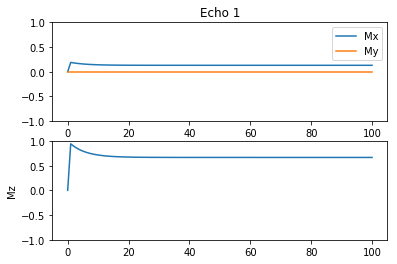

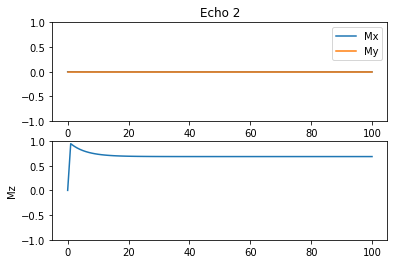

In [11]:
# M_echos should be a 3xN np array
def plot_echos(M_echos, title=''):
    
    def plot_train(_y, _y_label=''):
        plt.plot(_y)
        plt.ylim([-1, 1])
        plt.ylabel(_y_label)
    
    plt.figure()
    plt.subplot(211)    
    plot_train(M_echos[0, :])
    plot_train(M_echos[1, :])
    plt.title(title)
    plt.legend(['Mx', 'My'])
    plt.subplot(212)
    plot_train(M_echos[2, :], 'Mz')
    
    plt.show()
    
plot_echos(M_echos_1_eval, 'Echo 1')
plot_echos(M_echos_2_eval, 'Echo 2')

## Check Function Landscape

In [12]:
# do a quick check of what the function landscape looks like
TEs = np.linspace(2.5, 8, num=20)

crb_TE_list = []
crb_TE_corr_list = []
dcrb_dTE_list = []
M_echos_TE_ss_1_list = []
M_echos_TE_ss_2_list = []

for TE in TEs:
    M_echos_1_eval, M_echos_2_eval, crb_eval, crb_corr_eval, dcrb_dTE_plus_eval, dcrb_dTE_minus_eval, _, _ = \
        crb_grad(alpha0, TE, TE, TR0)
    
    M_echos_TE_ss_1_list.append(M_echos_1_eval[0, -1]) 
    M_echos_TE_ss_2_list.append(M_echos_2_eval[0, -1])
    
    crb_TE_list.append(crb_eval)
    crb_TE_corr_list.append(crb_corr_eval)
    dcrb_dTE_list.append(dcrb_dTE_plus_eval)

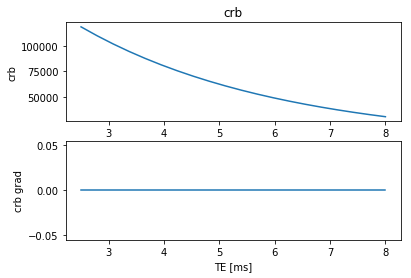

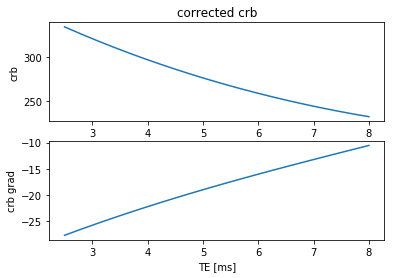

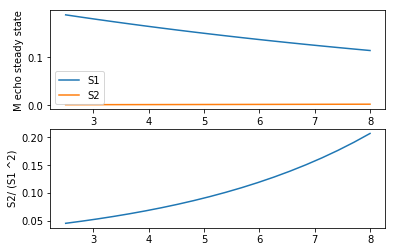

In [13]:
def plot_crb_and_crb_grad(x, crb_list, crb_dvar_list, _xlabel, _title=''):
    plt.figure()
    plt.subplot(211)
    plt.plot(x, crb_list)
    plt.ylabel('crb')
    plt.title(_title)
    plt.subplot(212)
    plt.plot(x, crb_dvar_list)
    plt.ylabel('crb grad')
    plt.xlabel(_xlabel)
    plt.show()    
    
def plot_ss_magnetization(x, echo_ss_1, echo_ss_2):
    plt.figure()
    plt.subplot(211)
    plt.plot(x, np.abs(np.array(echo_ss_1)))
    plt.plot(x, np.abs(np.array(echo_ss_2)))
    plt.ylabel('M echo steady state')
    plt.legend(['S1', 'S2'])
    plt.subplot(212)
    plt.plot(x, np.abs(np.array(echo_ss_2))/ np.power(np.array(echo_ss_1), 2))
    plt.ylabel('S2/ (S1 ^2)')
    plt.show()
    
plot_crb_and_crb_grad(TEs, crb_TE_list, np.zeros_like(crb_TE_list), 'TE [ms]', _title='crb')
plot_crb_and_crb_grad(TEs, crb_TE_corr_list, dcrb_dTE_list, 'TE [ms]', _title='corrected crb')
plot_ss_magnetization(TEs, M_echos_TE_ss_1_list, M_echos_TE_ss_2_list)

In [ ]:
alphas = np.linspace(10, 50, num=40)

crb_alpha_list = []
crb_alpha_corr_list = []
dcrb_dalpha_list = []
M_echos_alpha_ss_1_list = []
M_echos_alpha_ss_2_list = []

for alpha in alphas:
    M_echos_1_eval, M_echos_2_eval, crb_eval, crb_corr_eval, _, _, dcrb_dalpha_eval, _ = crb_grad(alpha, TE0, TE0, TR0)
        
    M_echos_alpha_ss_1_list.append(M_echos_1_eval[0, -1]) 
    M_echos_alpha_ss_2_list.append(M_echos_2_eval[0, -1])    
    
    crb_alpha_list.append(crb_eval)
    crb_alpha_corr_list.append(crb_corr_eval)
    dcrb_dalpha_list.append(dcrb_dalpha_eval)

In [ ]:
plot_crb_and_crb_grad(alphas, crb_alpha_list, np.zeros_like(crb_alpha_list), 'alpha [degrees]', _title='crb')
plot_crb_and_crb_grad(alphas, crb_alpha_corr_list, dcrb_dalpha_list, 'alpha [degrees]', _title='crb corr')

# plot numerical gradient
numerical_grad = (np.array(crb_alpha_corr_list)[1:] - np.array(crb_alpha_corr_list)[0:-1]) / (alphas[1] - alphas[0])
plt.figure()
plt.subplot(211)
plt.plot(alphas[0:-1], numerical_grad)
plt.ylabel('numerical grad')
plt.xlabel('alpha [degrees]')
plt.show()


plot_ss_magnetization(alphas, M_echos_alpha_ss_1_list, M_echos_alpha_ss_2_list)

## Sequence Optimization

$TE_{plus} = TE_{minus}$

In [ ]:
# make a wrapper, which accepts a numpy array, with order [alpha, TE_plus, TR]
def crb_obj_wrapper(x, *args):
    if(len(args)): # check cache
        cache_obj = args[0]

        if(cache_obj.check_cache(x)):
            crb_corr_eval, dcrb_dTE_plus_eval, dcrb_dalpha_eval, dcrb_dTR_eval = \
                cache_obj.get_cache()
            return crb_corr_eval
    
    _, _, _, crb_corr_eval, dcrb_dTE_plus_eval, _, dcrb_dalpha_eval, dcrb_dTR_eval = crb_grad(x[0], x[1], x[1], x[2])    
            
    if(len(args)): # update cache
        cache_obj.update_cache(x, (crb_corr_eval, dcrb_dTE_plus_eval, dcrb_dalpha_eval, dcrb_dTR_eval))       
        
    return crb_corr_eval
    
def crb_grad_wrapper(x, *args):       
    if(len(args)): # check cache
        cache_obj = args[0]

        if(cache_obj.check_cache(x)):
            crb_corr_eval, dcrb_dTE_plus_eval, dcrb_dalpha_eval, dcrb_dTR_eval = \
                cache_obj.get_cache()
            return np.array([dcrb_dalpha_eval, dcrb_dTE_plus_eval, dcrb_dTR_eval])
    
    _, _, _, crb_corr_eval, dcrb_dTE_plus_eval, _, dcrb_dalpha_eval, dcrb_dTR_eval = crb_grad(x[0], x[1], x[1], x[2])    
            
    if(len(args)): # update cache
        cache_obj.update_cache(x, (crb_corr_eval, dcrb_dTE_plus_eval, dcrb_dalpha_eval, dcrb_dTR_eval))    
        
        
    return np.array([dcrb_dalpha_eval, dcrb_dTE_plus_eval, dcrb_dTR_eval])
    
start_time = time.time()    
# try to optimize jointly over alpha, TE
x_init_alpha_sweep = np.linspace(10., 50., num=5)
#x_init_TR_sweep = np.array([20., 40.])
x_init_TR_sweep = np.array([20.])
x_optimal_list = np.array([[0], [0], [0]])
fx_list = np.array([0])

for x_init_TR_sweep in x_init_TR_sweep:
    for x_init_alpha in x_init_alpha_sweep:
        print('X_init_alpha ' + str(x_init_alpha))
        cache_obj = CacheStruct(is_verbose=False)
        x_init = np.array([x_init_alpha, 5.0, x_init_TR_sweep]) # degrees /ms / ms
        #x_bounds = [(10., 50.), (6.5, 8.5), (20.0, 40.0)] # ms
        x_bounds = [(10., 50.), (6.5, 8.5), (19.9, 20.1)] # ms

        optimize_args = {'bounds': x_bounds, 'args': (cache_obj,), 'fprime':crb_grad_wrapper, 'iprint':2}

        x_optimal = scipy.optimize.fmin_slsqp(crb_obj_wrapper, 
                                  x_init,
                                  **optimize_args)

        alpha_opt = x_optimal[0]
        TE_opt = x_optimal[1]
        TR_opt = x_optimal[2]

        x_optimal_list = np.concatenate((x_optimal_list, x_optimal[:, np.newaxis]), axis=1)
        #fx_list.append(fx)

        print(x_optimal)
        print('Cache Hits: ' + str(cache_obj.get_cache_hits()))

elapsed_time = time.time() - start_time
print('Elapsed time ' + str(elapsed_time))